<a href="https://colab.research.google.com/github/Angel0503/DeepLearning/blob/master/TD3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [351]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler


## Exercice 1 - Séries temporelles

### 1 - Télécharger un dataset contenant l’historique des cotations d’une action de votre choix (votre entreprise en alternance, facebook, google, CAC40, etc.). Vous trouverez ce qu’il faut ici : https://www.nasdaq.com. Il est conseillé de prendre la plus grande période possible pour avoir le dataset le plus grand possible

### 2 - Charger le fichier CSV en python et explorer le dataset. Proposer une ou plusieurs représentations graphiques permettant de visualiser les données.

In [352]:
df = pd.read_csv('NVIDIA_stocks.csv')

In [353]:
df.describe()

,Volume
count,2.514000e+03
mean,4.594593e+08
std,2.556077e+08
min,5.244924e+07
25%,2.945382e+08
50%,4.104501e+08
75%,5.597640e+08
max,3.688132e+09


In [354]:
df.head(10)

,Date,Close/Last,Volume,Open,High,Low
0,11/06/2025,$188.08,223029800,$196.42,$197.62,$186.38
1,11/05/2025,$195.21,171350300,$198.77,$202.92,$194.65
2,11/04/2025,$198.69,188919300,$203.00,$203.9699,$197.93
3,11/03/2025,$206.88,180267300,$208.08,$211.335,$205.56
4,10/31/2025,$202.49,179802200,$206.45,$207.97,$202.07
5,10/30/2025,$202.89,178864400,$205.15,$206.16,$201.41
6,10/29/2025,$207.04,308829600,$207.98,$212.1899,$204.775
7,10/28/2025,$201.03,297986200,$193.05,$203.15,$191.91
8,10/27/2025,$191.49,153452700,$189.99,$192.00,$188.4318
9,10/24/2025,$186.26,131296700,$183.835,$187.47,$183.50


In [355]:
df.isnull().sum()

Date          0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64

In [356]:
df.dtypes

Date          object
Close/Last    object
Volume         int64
Open          object
High          object
Low           object
dtype: object

In [357]:
df['Close/Last'] = df['Close/Last'].apply(lambda x: float(x.split('$')[1]))
df['Date'] = pd.to_datetime(df['Date'])
df['Open'] = df['Open'].apply(lambda x: float(x.split('$')[1]))
df['High'] = df['High'].apply(lambda x: float(x.split('$')[1]))
df['Low'] = df['Low'].apply(lambda x: float(x.split('$')[1]))

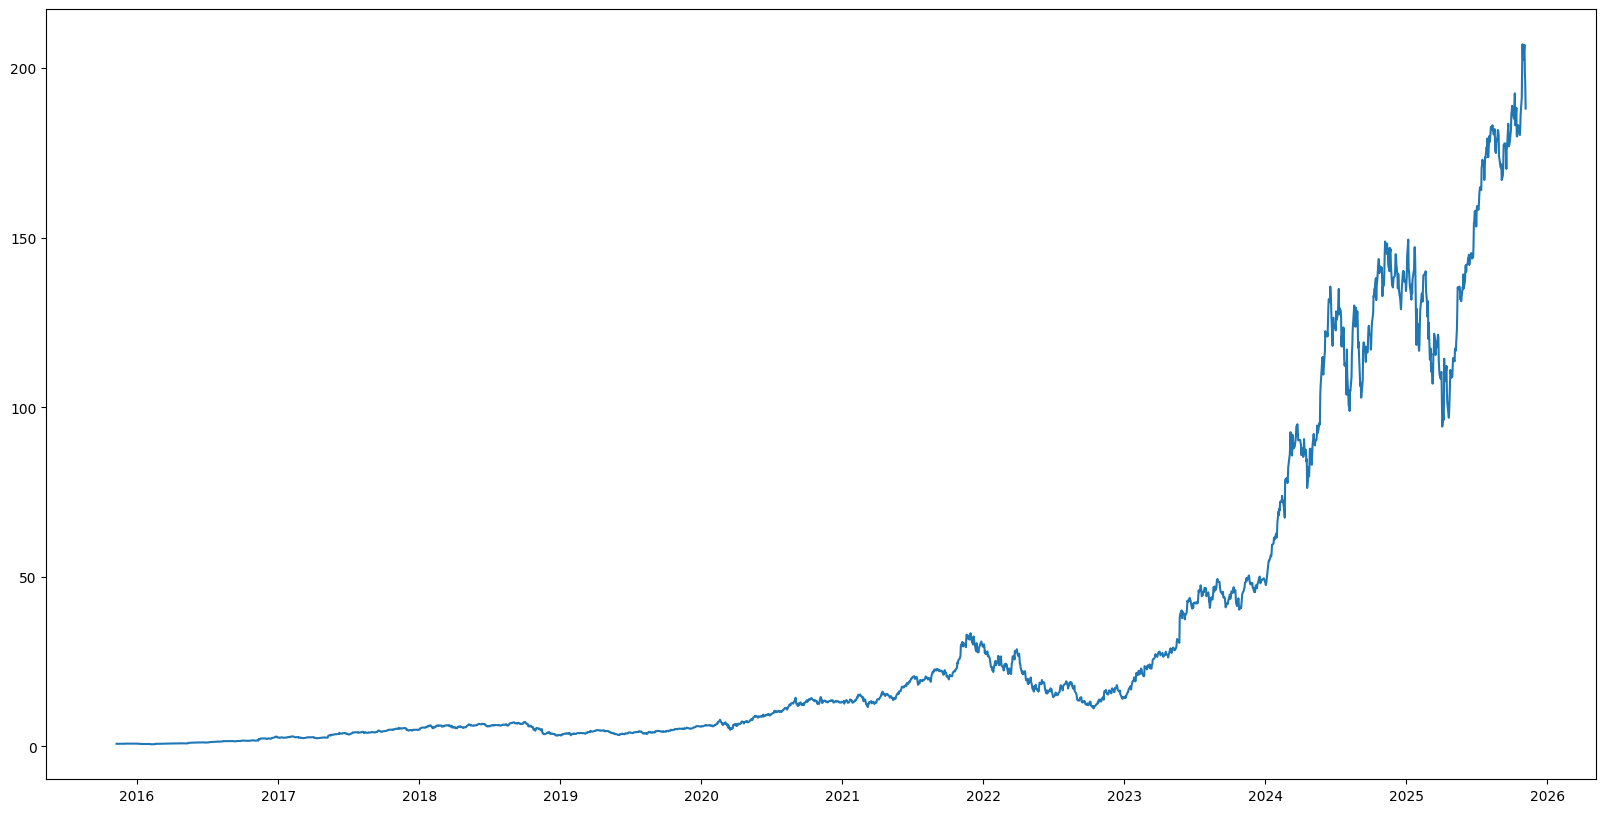

In [358]:
plt.figure(figsize=(20,10))
plt.plot(df['Date'], df['Close/Last'])
plt.show()

### 3 - Sélectionner la ou les colonnes permettant la prédiction les cotations de l’action sélectionnée.

In [359]:
df = df.sort_values('Date', ascending=True)
stock_values = df[['Close/Last']]

### 4 - Préparer un dataset d’entrainement et de test pour l’apprentissage. En particulier, le dataset doit être constitué de séquences de valeurs (en entrée) permettant de prédire la (ou les) valeur(s) suivante(s) de cette séquence (target).

MinMaxScaler sur les données

Créé algo pour créer dataset qui prend les 60 premières valeurs pour le X et la 61 eme est le Y sur tout le dataset.
Puis pour le train-test, il faut le faire à la main car il faut garder l'ordre.

#### Standardiser les données

In [360]:
scaler = MinMaxScaler()
stock_values_scaled = scaler.fit_transform(stock_values)

#### Créer la séquence

In [374]:
data_X = []
data_Y = []

def create_sequences_multi(data, decalage, horizon=1):
    data = np.asarray(data)
    if data.ndim == 1:
        data = data.reshape(-1, 1)
    T, n_features = data.shape

    max_start = T - decalage - horizon + 1
    X, y = [], []
    for i in range(max_start):
        seq = data[i:i+decalage]
        future = data[i+decalage : i+decalage+horizon]
        X.append(seq)

        if n_features == 1:
            y.append(future.flatten())
        else:
            y.append(future)
    X = np.array(X)
    y = np.array(y)

    # Keep the feature dimension: (samples, decalage, n_features)
    X = X.reshape(X.shape[0], X.shape[1], n_features)

    return X, y


decalage = 60
data_X, data_Y = create_sequences_multi(stock_values_scaled, decalage)

In [375]:
print(data_X.shape)
print(data_Y.shape)

(2454, 60, 1)
(2454, 1)


In [376]:
sequential_df = pd.DataFrame({'x':data_X.tolist(), 'y':data_Y.tolist()})

#### Générer le jeu de test et train

In [377]:
n_total = len(stock_values_scaled)
N_seq = n_total - decalage
split_idx = int(N_seq * 0.7)

train_df = sequential_df.iloc[:split_idx]
test_df = sequential_df.iloc[split_idx:]

print(train_df.shape, test_df.shape)

(1717, 2) (737, 2)


In [378]:
X_train = np.array(train_df['x'].tolist())
y_train = np.array(train_df['y'].tolist())

X_test = np.array(test_df['x'].tolist())
y_test = np.array(test_df['y'].tolist())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1717, 60, 1) (1717, 1)
(737, 60, 1) (737, 1)


### 5 - Proposer et comparer quelques architectures neuronales à partir de couches LSTM et GRU. Sélectionner celle permettant d’obtenir les meilleurs résultats. Dans cette question, la prédiction doit être faite à très court terme. Vous pouvez aussi utiliser des couches convolutionnel 1D pour évaluer l’impact de la mémoire long terme.

#### LSTM

In [379]:
model = tf.keras.Sequential()

# Couche d'entrée de 60 neuronnes
model.add(tf.keras.Input(shape=(60,1)))
# Couche LSTM
model.add(tf.keras.layers.LSTM(50, return_sequences=True))
model.add(tf.keras.layers.LSTM(50, return_sequences=True))
model.add(tf.keras.layers.LSTM(50))
# Couche de sortir dense de 1 neuronne sans fonction d'activation
model.add(tf.keras.layers.Dense(1, activation=None))

adam = tf.keras.optimizers.Adam()
model.compile(loss='mean_squared_error', optimizer=adam)

In [380]:
model.fit(X_train, y_train, epochs=100, verbose=1, batch_size=128)

Epoch 1/100


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0011
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.3123e-04
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 5.5338e-05
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 4.1445e-05
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 3.3261e-05
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 3.0977e-05
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 3.2953e-05
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 3.0233e-05
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 2.8960e-05
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 2.7866e-05
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 2.5252e-05
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 2.5530e-05
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 2.5757e-05
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 2.7200e-05
Epoch 15/100
14/1

In [381]:
test_mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Test mse : {test_mse:.4f}")

train_mse = model.evaluate(X_train, y_train, verbose=0)
print(f"Train mse : {train_mse:.4f}")

Test mse : 0.0044
Train mse : 0.0000


In [382]:
train_date_df = df['Date'].iloc[decalage : decalage + split_idx].reset_index(drop=True)
test_date_df  = df['Date'].iloc[decalage + split_idx : decalage + N_seq].reset_index(drop=True)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

test_pred_lstm = scaler.inverse_transform(test_pred.reshape(-1,1)).ravel()
train_pred_lstm = scaler.inverse_transform(train_pred.reshape(-1,1)).ravel()

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [383]:
test_pred_lstm.shape

(737,)

In [384]:
test_date_df.shape

(737,)

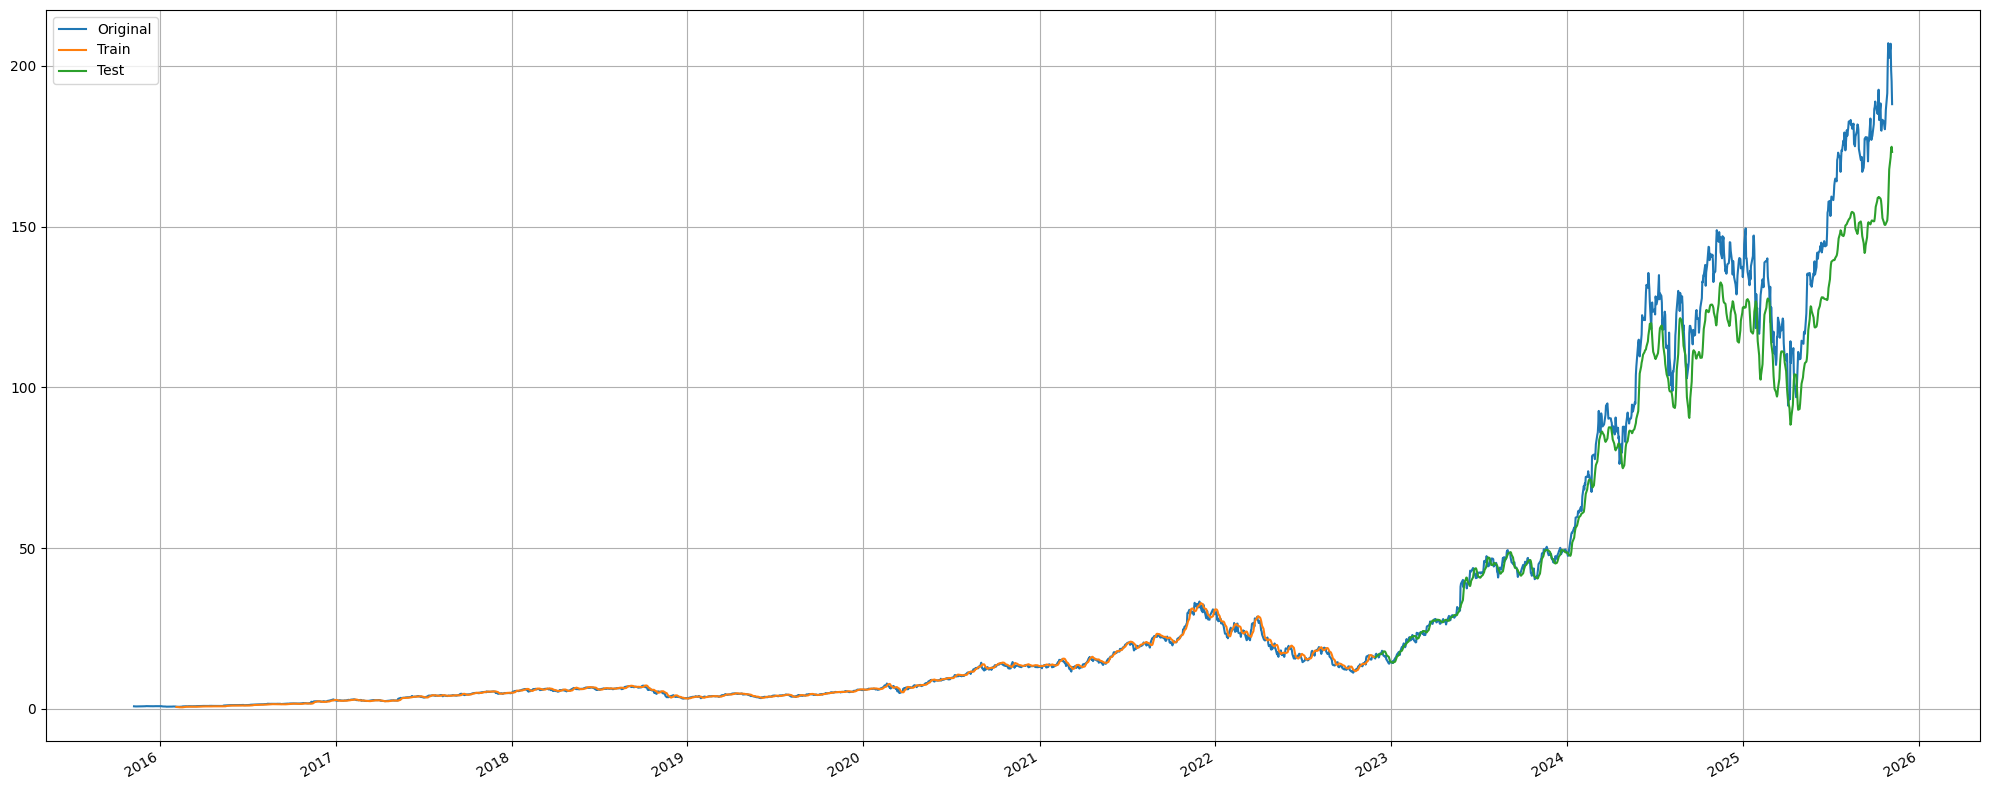

In [385]:
plt.figure(figsize=(20,8))
plt.plot(df['Date'], stock_values, color='C0', label='Original')
plt.plot(train_date_df, train_pred_lstm, color='C1', label='Train')
plt.plot(test_date_df,  test_pred_lstm,  color='C2', label='Test')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)
plt.tight_layout()
plt.show()

#### GRU

In [ ]:
model_2 = tf.keras.Sequential()

# Couche d'entrée de 60 neuronnes
model_2.add(tf.keras.Input(shape=(60,1)))
# Couche GRU
model_2.add(tf.keras.layers.GRU(50, return_sequences=True))
model_2.add(tf.keras.layers.GRU(50, return_sequences=True))
model_2.add(tf.keras.layers.GRU(50))
# Couche de sortir dense de 1 neuronne sans fonction d'activation
model_2.add(tf.keras.layers.Dense(1, activation=None))

adam = tf.keras.optimizers.Adam()
model_2.compile(loss='mean_squared_error', optimizer=adam)

In [ ]:
model_2.fit(X_train, y_train, epochs=100, verbose=1, batch_size=128)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0014
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 1.0960e-04
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 2.8171e-05
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 1.3859e-05
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.1848e-05
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.0781e-05
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 1.0705e-05
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 1.1022e-05
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 1.1213e-05
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 1.1449e-05
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 1.0107e-05
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.0299e-05
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.0480e-05
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 9.5446e-06
Epoch

In [ ]:
test_mse = model_2.evaluate(X_test, y_test, verbose=0)
print(f"Test mse : {test_mse:.4f}")

train_mse = model_2.evaluate(X_train, y_train, verbose=0)
print(f"Train mse : {train_mse:.4f}")

Test mse : 0.0007
Train mse : 0.0000


In [ ]:
train_date_df = df['Date'].iloc[decalage : decalage + split_idx].reset_index(drop=True)
test_date_df  = df['Date'].iloc[decalage + split_idx : decalage + N_seq].reset_index(drop=True)

test_pred = model_2.predict(X_test)
train_pred = model_2.predict(X_train)

test_pred_gru = scaler.inverse_transform(test_pred.reshape(-1,1)).ravel()
train_pred_gru = scaler.inverse_transform(train_pred.reshape(-1,1)).ravel()

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


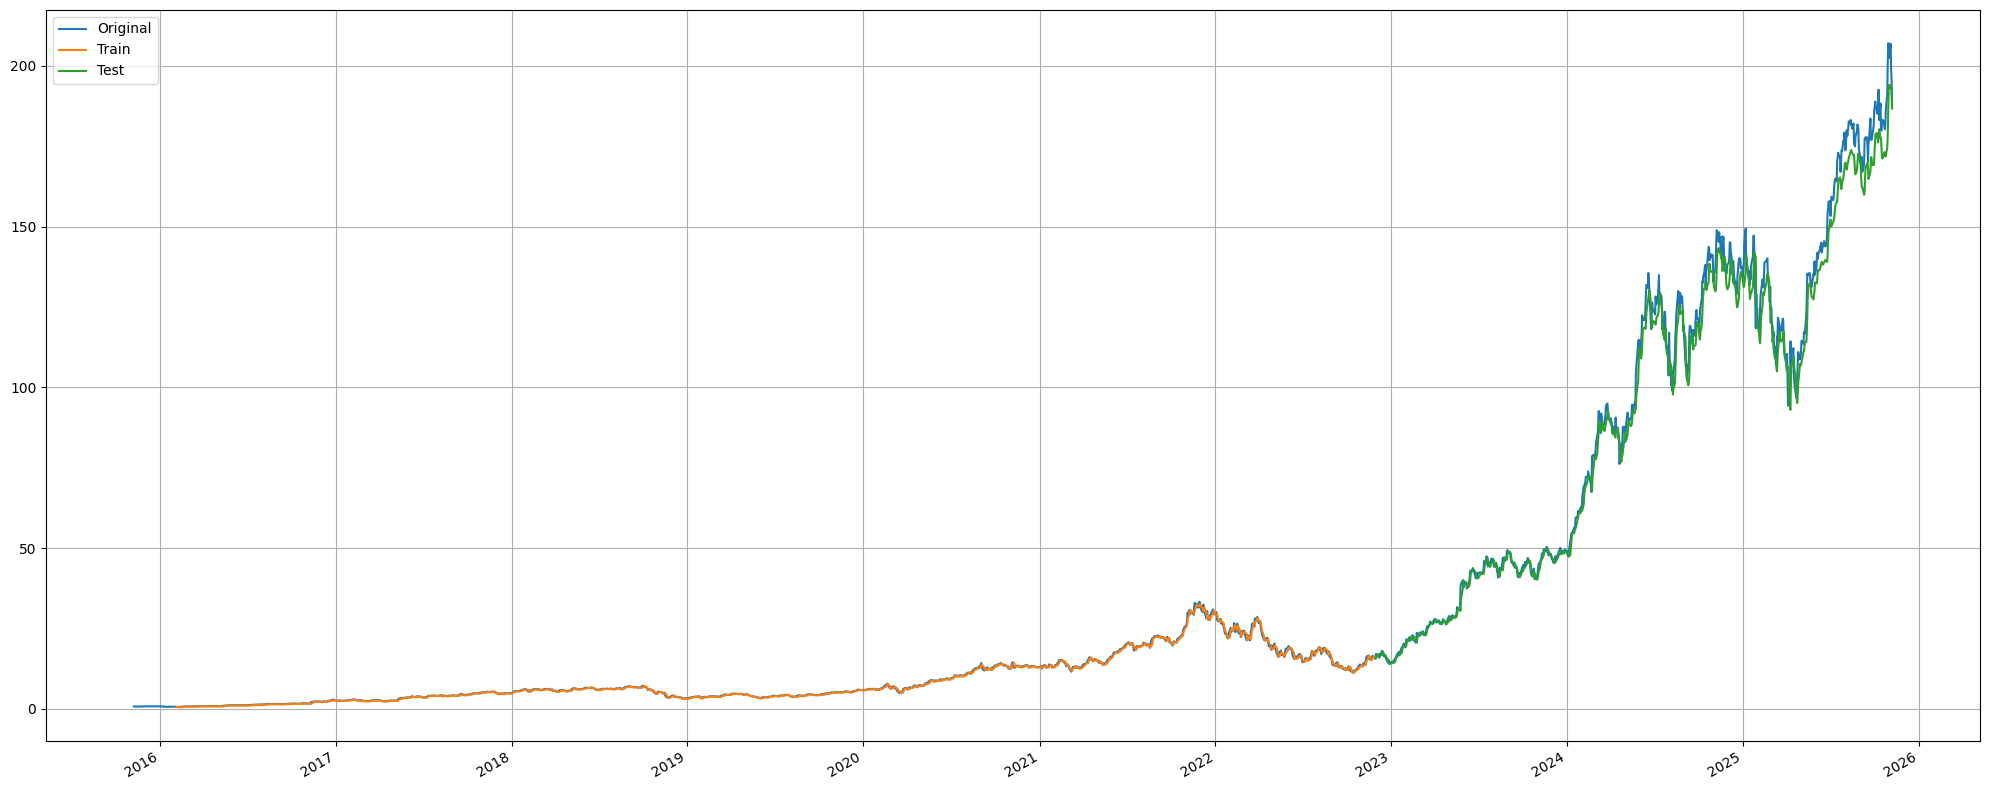

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(df['Date'], stock_values, color='C0', label='Original')
plt.plot(train_date_df, train_pred_gru, color='C1', label='Train')
plt.plot(test_date_df,  test_pred_gru,  color='C2', label='Test')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)
plt.tight_layout()
plt.show()

### 6 - Explorer la capacité de prédiction de ce système sur des plus long terme (prédiction à plusieurs jours).

In [386]:
data_X, data_Y = create_sequences_multi(stock_values_scaled, decalage, 30)

sequential_df = pd.DataFrame({'x':data_X.tolist(), 'y':data_Y.tolist()})
n_total = len(stock_values_scaled)
N_seq = n_total - decalage
split_idx = int(N_seq * 0.7)

train_df = sequential_df.iloc[:split_idx]
test_df = sequential_df.iloc[split_idx:]
X_train = np.array(train_df['x'].tolist())
y_train = np.array(train_df['y'].tolist())

X_test = np.array(test_df['x'].tolist())
y_test = np.array(test_df['y'].tolist())

#### LSTM - Month prediction

In [387]:
lstm_month = tf.keras.Sequential()

# Couche d'entrée de 60 neuronnes
lstm_month.add(tf.keras.Input(shape=(60,1)))
# Couche LSTM
lstm_month.add(tf.keras.layers.LSTM(50, return_sequences=True))
lstm_month.add(tf.keras.layers.LSTM(50, return_sequences=True))
lstm_month.add(tf.keras.layers.LSTM(50))
# Couche de sortir dense de 30 neuronne sans fonction d'activation
lstm_month.add(tf.keras.layers.Dense(30, activation=None))

adam = tf.keras.optimizers.Adam()
lstm_month.compile(loss='mean_squared_error', optimizer=adam)

In [388]:
lstm_month.fit(X_train, y_train, epochs=100, verbose=1, batch_size=128)

Epoch 1/100


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0022
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 7.3420e-04
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.7237e-04
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 1.2026e-04
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 9.8312e-05
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 9.8187e-05
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 9.8782e-05
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 9.0100e-05
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 8.6398e-05
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 9.8023e-05
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 8.4411e-05
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 8.9279e-05
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 8.4947e-05
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 8.9985e-05
Epoch 15/100
14/1

In [389]:
test_mse = lstm_month.evaluate(X_test, y_test, verbose=0)
print(f"Test mse : {test_mse:.4f}")

train_mse = lstm_month.evaluate(X_train, y_train, verbose=0)
print(f"Train mse : {train_mse:.4f}")

Test mse : 0.0586
Train mse : 0.0001
